In [1]:
%matplotlib inline

import os
import gc
import torch
# import muon
import numpy as np
import scanpy as sc
import pandas as pd
import scipy
import dask.dataframe as dd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import StandardScaler

In [2]:
%%time

# raw_path_base = '../../../input/raw/'
# raw_path = '../../../input/preprocess/cite/'
# raw_multi_path = '../../../input/preprocess/multi/'
# feature_path = '../../../input/base_features/cite/'
#feature_path = '../../../../summary/input/sample/'

lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'

raw_path_base = lrz_path + 'input/raw/'
raw_path = lrz_path + 'input/preprocess/cite/'
# raw_multi_path = lrz_path + 'input/preprocess/multi/'
feature_path = lrz_path + 'input/base_features/cite/'


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs


In [3]:
# df_meta = pd.read_csv(raw_path_base + 'metadata.csv')
df_meta = pd.read_csv('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/neurips_competition_data/' + 'metadata.csv')

In [4]:
train_inputs = scipy.sparse.load_npz(raw_path + "train_cite_raw_inputs_values.sparse.npz")
test_inputs = scipy.sparse.load_npz(raw_path + "test_cite_raw_inputs_values.sparse.npz")

In [5]:
train_inputs.toarray().shape

(70988, 22085)

In [6]:
train_ids = np.load(raw_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_ids = np.load(raw_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)

train_index = train_ids["index"]
train_column = train_ids["columns"]
test_index = test_ids["index"]

In [7]:
len(train_index)

70988

In [8]:
train_num = train_inputs.shape[0]

In [9]:
all_inputs = scipy.sparse.vstack([train_inputs, test_inputs])

In [10]:
# cluster
cluster = pd.read_pickle(raw_path + 'cite_cluster.pickle')
all_cluster = pd.read_pickle(raw_path + 'allrna_cluster.pickle')

scluster_train = pd.read_pickle(raw_path + 'train_spec_cluster_128.pickle')
scluster_test = pd.read_pickle(raw_path + 'test_spec_cluster_128.pickle')
s_cluster = pd.concat([scluster_train, scluster_test])
del scluster_train, scluster_test
gc.collect()

0

### important gene
- Two patterns of important proteins are selected based on the correlation of the objective variable and other variables.(84 proteins, 120 proteins)

In [11]:
# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))

next_important_cols = ['ENSG00000211899_IGHM',
 'ENSG00000160883_HK3',
 'ENSG00000137818_RPLP1',
 'ENSG00000183087_GAS6',
 'ENSG00000198520_ARMH1',
 'ENSG00000175449_RFESD',
 'ENSG00000106443_PHF14',
 'ENSG00000164929_BAALC',
 'ENSG00000133142_TCEAL4',
 'ENSG00000198336_MYL4',
 'ENSG00000103490_PYCARD',
 'ENSG00000223609_HBD',
 'ENSG00000204257_HLA-DMA',
 'ENSG00000204472_AIF1',
 'ENSG00000136942_RPL35',
 'ENSG00000204525_HLA-C',
 'ENSG00000184500_PROS1',
 'ENSG00000133985_TTC9',
 'ENSG00000198727_MT-CYB',
 'ENSG00000231389_HLA-DPA1',
 'ENSG00000198502_HLA-DRB5',
 'ENSG00000112339_HBS1L',
 'ENSG00000149806_FAU',
 'ENSG00000110852_CLEC2B',
 'ENSG00000104432_IL7',
 'ENSG00000100911_PSME2',
 'ENSG00000160789_LMNA',
 'ENSG00000140022_STON2',
 'ENSG00000118579_MED28',
 'ENSG00000138326_RPS24',
 'ENSG00000133134_BEX2',
 'ENSG00000171388_APLN',
 'ENSG00000198899_MT-ATP6',
 'ENSG00000223865_HLA-DPB1',
 'ENSG00000198804_MT-CO1',
 'ENSG00000101608_MYL12A']

print('next important columns ',len(next_important_cols))

Constant cols: 1194
important columns  84
next important columns  36


In [12]:
important_cols_84 = important_cols
important_cols_120 = important_cols + next_important_cols

use_imp_cols_84 =  [i for i, j in enumerate(train_column) if j in important_cols_84]
use_cols_84 = [i for i, j in enumerate(train_column) if j not in important_cols_84]
norm_cols_84 = [j for i, j in enumerate(train_column) if j not in important_cols_84]

use_imp_cols_120 =  [i for i, j in enumerate(train_column) if j in important_cols_120]
use_cols_120 = [i for i, j in enumerate(train_column) if j not in important_cols_120]
norm_cols_120 = [j for i, j in enumerate(train_column) if j not in important_cols_120]

print(len(use_imp_cols_84), len(use_imp_cols_120))
print(len(use_cols_84), len(use_cols_120))

84 120
22001 21965


In [13]:
len(train_column)

22085

In [14]:
train_column[[use_imp_cols_84[80]]]

array(['ENSG00000072274_TFRC'], dtype=object)

In [15]:
use_imp_cols_84    # indices of important cols in train_column

[3290,
 4010,
 4743,
 4841,
 5172,
 5260,
 5619,
 5632,
 5939,
 6120,
 6699,
 6704,
 6705,
 6710,
 6713,
 6714,
 6716,
 6720,
 6733,
 6734,
 6735,
 6737,
 6741,
 6744,
 6749,
 6750,
 6756,
 6759,
 6761,
 6762,
 6763,
 6768,
 6771,
 6774,
 6777,
 7292,
 7338,
 7616,
 7688,
 7772,
 8238,
 8747,
 9331,
 9602,
 9908,
 9948,
 10500,
 10588,
 10589,
 10602,
 10603,
 10606,
 10732,
 10904,
 10937,
 10956,
 11309,
 11398,
 11597,
 11662,
 13011,
 13390,
 13801,
 14785,
 15124,
 15266,
 15571,
 16503,
 17087,
 17138,
 17323,
 17339,
 17512,
 17514,
 17750,
 17826,
 18436,
 18449,
 18660,
 18762,
 19495,
 19923,
 20095,
 20883]

### base features
- Compressed with svd (except for important genes)

In [16]:
def make_train_svds(df, use_cols, use_imp_cols, svd_dims, svd_save_name, imp_save_name, imp_ratio_name, express = False):

    
    
    df_use = df[:, use_cols]
    #print(df_use)
    df_use = sc.AnnData(X = df_use)
    #print(df_use.X)
    if express == True:
        sc.pp.normalize_total(df_use, exclude_highly_expressed=True, max_fraction=0.005)
    else:
        sc.pp.normalize_per_cell(df_use)
    sc.pp.log1p(df_use.X)
#     print(df_use)
    svd = TruncatedSVD(n_components=svd_dims, random_state=1) # 512
    result_svd = svd.fit_transform(df_use.X)
#     print(result_svd)
    train_cite_pp = pd.DataFrame(result_svd[:train_num], index = train_ids['index'])   # has cell_ids
    test_cite_pp = pd.DataFrame(result_svd[train_num:], index = test_ids['index'])     # has cell_ids

    if express == True:
        # Sorry for the weird naming, I was confused because I was making various features,
        # last_v4 feature is changed the normalize method.
        #train_cite_pp.to_pickle(feature_path + f'train_cite_last_svd_v4.pickle')
        #test_cite_pp.to_pickle(feature_path + f'test_cite_last_svd_v4.pickle')
        print(1)
    else:
        print(2)
        #train_cite_pp.to_pickle(feature_path + f'train_{svd_save_name}.pickle')
        #test_cite_pp.to_pickle(feature_path + f'test_{svd_save_name}.pickle')
        print(f'test_{svd_save_name}')

    # important protein cols ---------------------------------------------------------------------

    if imp_save_name is not None:

        df_important = df[:, use_imp_cols]
        df_important = sc.AnnData(X = df_important)
        sc.pp.normalize_per_cell(df_important)
        sc.pp.log1p(df_important)

        train_imp = pd.DataFrame(df_important.X[:train_num].toarray(), index = train_ids['index']).add_prefix('imp_')
        test_imp = pd.DataFrame(df_important.X[train_num:].toarray(), index = test_ids['index']).add_prefix('imp_')

        #train_imp.to_pickle(feature_path + f'train_{imp_save_name}.pickle')
        #test_imp.to_pickle(feature_path + f'test_{imp_save_name}.pickle')

        # import protain surface ratio
        imp_ratio = df[:,use_imp_cols].sum(1) / df.sum(1)
        imp_ratio_df = pd.DataFrame(imp_ratio, columns = ['knn_imp_ratio_all'])

        #imp_ratio_df[:train_num].reset_index(drop=True).to_pickle(feature_path + f'train_imp_feature_{imp_ratio_name}.pickle')
        #imp_ratio_df[train_num:].reset_index(drop=True).to_pickle(feature_path + f'test_imp_feature_{imp_ratio_name}.pickle')

In [ ]:
make_train_svds(all_inputs, use_cols_84, use_imp_cols_84, 128, 'svd_128_imp84', 'imp_84', 'imp84')    # for model #16
# make_train_svds(all_inputs, use_cols_84, use_imp_cols_84, 64, 'svd_64_imp84', None, None)
# make_train_svds(all_inputs, use_cols_120, use_imp_cols_120, 128, 'svd_128_imp120', 'imp_120','imp120')
# make_train_svds(all_inputs, use_cols_120, use_imp_cols_120, 64, 'svd_64_imp120', None, None)
# make_train_svds(all_inputs, use_cols_120, use_imp_cols_120, 128, 'svd_128_imp120', None, None, True)

In [49]:
pd.DataFrame(sc.AnnData(all_inputs[:, use_imp_cols_84]).X[:train_num].toarray(),index = train_ids['index'], columns=list(train_column[[use_imp_cols_84]]))

,ENSG00000075340_ADD2,ENSG00000233968_AL157895.1,ENSG00000029534_ANK1,ENSG00000135046_ANXA1,ENSG00000130208_APOC1,ENSG00000047648_ARHGAP6,ENSG00000101200_AVP,ENSG00000166710_B2M,ENSG00000130303_BST2,ENSG00000172247_C1QTNF4,...,ENSG00000188404_SELL,ENSG00000124570_SERPINB6,ENSG00000235169_SMIM1,ENSG00000095932_SMIM24,ENSG00000137642_SORL1,ENSG00000128040_SPINK2,ENSG00000072274_TFRC,ENSG00000205542_TMSB4X,ENSG00000133112_TPT1,ENSG00000026025_VIM
45006fe3e4c8,0.0,0.0,0.0,12.0,0.0,0.0,13.0,37.0,5.0,2.0,...,3.0,5.0,0.0,6.0,0.0,10.0,4.0,49.0,101.0,8.0
d02759a80ba2,0.0,0.0,0.0,6.0,0.0,0.0,1.0,40.0,4.0,3.0,...,1.0,2.0,0.0,3.0,0.0,4.0,0.0,29.0,83.0,7.0
c016c6b0efa5,1.0,1.0,3.0,2.0,6.0,0.0,0.0,33.0,0.0,0.0,...,0.0,0.0,3.0,1.0,0.0,0.0,3.0,12.0,65.0,0.0
ba7f733a4f75,0.0,0.0,0.0,7.0,0.0,0.0,0.0,44.0,11.0,0.0,...,1.0,5.0,0.0,2.0,0.0,0.0,2.0,59.0,107.0,12.0
fbcf2443ffb2,0.0,2.0,2.0,7.0,4.0,0.0,0.0,19.0,0.0,0.0,...,0.0,2.0,5.0,0.0,0.0,0.0,27.0,26.0,77.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,1.0,0.0,3.0,0.0,0.0,2.0,39.0,5.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,1.0,29.0,74.0,3.0
cc506e7707f5,1.0,0.0,4.0,2.0,1.0,0.0,0.0,31.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,11.0,18.0,51.0,0.0
a91f1b55a520,2.0,1.0,1.0,3.0,5.0,0.0,0.0,24.0,0.0,0.0,...,1.0,3.0,2.0,0.0,0.0,0.0,18.0,25.0,47.0,0.0
3a9882c98205,0.0,0.0,0.0,25.0,0.0,0.0,0.0,24.0,2.0,0.0,...,2.0,1.0,0.0,0.0,1.0,0.0,7.0,82.0,75.0,4.0


In [26]:
'train_svd_128_imp84.pickle'

'train_svd_128_imp84.pickle'

In [24]:
%%time
df_use = all_inputs[:, use_cols_84]
df_use = sc.AnnData(X = df_use)
sc.pp.normalize_per_cell(df_use)
sc.pp.log1p(df_use.X)
print(df_use.X)

  (0, 11)	0.8783691
  (0, 12)	1.3386633
  (0, 14)	0.8783691
  (0, 19)	0.8783691
  (0, 20)	1.8912855
  (0, 23)	1.3386633
  (0, 32)	0.8783691
  (0, 54)	1.3386633
  (0, 56)	1.3386633
  (0, 57)	1.6526723
  (0, 58)	0.8783691
  (0, 67)	0.8783691
  (0, 70)	1.3386633
  (0, 75)	0.8783691
  (0, 76)	1.3386633
  (0, 80)	0.8783691
  (0, 86)	1.6526723
  (0, 95)	0.8783691
  (0, 97)	2.0837889
  (0, 98)	0.8783691
  (0, 99)	0.8783691
  (0, 100)	1.3386633
  (0, 133)	1.3386633
  (0, 177)	0.8783691
  (0, 178)	0.8783691
  :	:
  (119190, 21900)	0.5147621
  (119190, 21905)	0.5147621
  (119190, 21906)	1.1051645
  (119190, 21910)	0.5147621
  (119190, 21912)	0.5147621
  (119190, 21925)	0.5147621
  (119190, 21931)	0.5147621
  (119190, 21942)	1.4738935
  (119190, 21943)	0.8529167
  (119190, 21944)	0.8529167
  (119190, 21945)	0.8529167
  (119190, 21946)	0.5147621
  (119190, 21948)	0.8529167
  (119190, 21949)	0.5147621
  (119190, 21958)	0.5147621
  (119190, 21959)	1.3064288
  (119190, 21962)	0.5147621
  (119190, 219

In [18]:
df_use.X.shape

(119191, 22001)

In [19]:
%%time
svd = TruncatedSVD(n_components=128, random_state=1)
result_svd = svd.fit_transform(df_use.X)
print(result_svd)
# train_cite_pp = pd.DataFrame(result_svd[:train_num], index = train_ids['index'])
# test_cite_pp = pd.DataFrame(result_svd[train_num:], index = test_ids['index'])

[[ 8.3281059e+01 -6.5636873e+00 -7.5164976e+00 ... -1.0894358e+00
   3.2031307e-01 -2.8350663e-01]
 [ 8.2476021e+01 -4.7658610e+00 -1.0963954e+01 ... -6.6031480e-01
   3.5743371e-02 -3.0017415e-01]
 [ 8.1887825e+01 -4.9204535e+00 -1.9316729e+00 ...  2.6188394e-01
   7.7779686e-01  4.4334182e-01]
 ...
 [ 7.9684784e+01  9.4281750e+00  1.3557551e+01 ... -9.5046449e-01
   3.5024157e-01  7.1377760e-01]
 [ 8.3006081e+01 -2.1711040e+00  3.2579702e-01 ...  1.9154297e-01
  -1.1333281e-02  6.4319021e-01]
 [ 8.6400101e+01 -8.7315645e+00  4.6385102e+00 ... -6.2591158e-02
   2.9216939e-01  2.0206447e-01]]
CPU times: user 11min 17s, sys: 4.47 s, total: 11min 21s
Wall time: 11min 14s


In [20]:
pd.DataFrame(result_svd)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,83.281059,-6.563687,-7.516498,3.435710,-8.191517,0.490795,1.647467,1.167566,-2.731280,0.720675,...,-0.461493,0.585050,-1.581415,0.836849,0.382400,-0.156138,0.217115,-1.089436,0.320313,-0.283507
1,82.476021,-4.765861,-10.963954,4.910066,-9.272614,2.528403,1.478672,-0.542885,1.255432,-1.079146,...,0.647600,0.107936,-0.032480,0.654824,-1.018406,-0.227682,0.659757,-0.660315,0.035743,-0.300174
2,81.887825,-4.920454,-1.931673,2.259549,9.677330,8.383811,-4.828906,-5.170604,1.990828,2.317710,...,-0.496323,-0.113403,-0.108198,-0.570026,0.079433,-0.277450,0.056143,0.261884,0.777797,0.443342
3,89.633156,-3.208730,-0.260160,-10.103559,-5.034528,4.842731,7.163779,0.373034,0.722552,1.930781,...,0.722054,0.038972,-0.204838,0.461687,-0.054005,0.539513,0.116842,-1.182438,0.060562,0.490287
4,91.496529,-9.532856,9.166341,-4.111490,1.666674,1.485301,-1.393139,0.572235,-8.316234,1.448510,...,0.606755,0.134050,0.012063,-0.335895,-0.268094,-0.309250,-1.055441,0.625480,-0.965516,0.856348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119186,83.781845,0.167031,-7.625717,1.275733,-3.755007,0.783169,3.680861,-0.550919,0.846298,4.215569,...,0.160800,-0.029528,0.229397,0.183500,-0.215809,0.304162,-0.360400,0.083125,0.177883,-0.192456
119187,79.464088,5.140545,-11.211595,1.652752,0.794648,-1.240072,1.638385,-1.543988,0.893215,3.862797,...,-0.835871,0.112912,-0.737379,0.053217,0.642194,-0.993530,0.337827,1.329903,0.574967,-0.944368
119188,79.684784,9.428175,13.557551,15.520265,10.519946,-4.048905,20.526196,5.015813,0.767968,-0.664279,...,0.058709,1.303856,-0.980460,0.768295,0.051655,-0.200603,-0.019306,-0.950464,0.350242,0.713778
119189,83.006081,-2.171104,0.325797,3.708027,13.180615,7.374112,-3.657790,-4.584086,2.395246,0.864618,...,-0.204323,0.719307,0.660412,-0.031210,-0.090650,-0.354362,0.136426,0.191543,-0.011333,0.643190


In [17]:
import pickle
# with open('svd_model.pkl', 'wb') as file:
#     pickle.dump(svd, file)

In [18]:
with open('svd_model.pkl', 'rb') as file:
    svd_loaded = pickle.load(file)

print(svd_loaded.components_.shape)
svd_loaded.components_

(128, 22001)


array([[ 1.7738342e-04,  4.2449028e-04,  5.6019730e-05, ...,
         2.9608321e-03,  8.3728144e-03,  2.1717523e-03],
       [ 3.4061831e-04,  3.9883706e-04,  5.4583960e-04, ...,
         1.0445307e-03,  1.4130343e-02,  3.1157960e-03],
       [-4.1849897e-04, -3.4455024e-05,  7.1493894e-05, ...,
         2.9243894e-03,  6.1457097e-03,  4.0481603e-03],
       ...,
       [ 1.4364810e-04, -3.7158822e-04,  2.2584604e-04, ...,
        -1.4209942e-04, -1.6503995e-02,  2.6346368e-04],
       [-8.8143779e-04, -5.2309851e-04,  7.4197771e-04, ...,
        -2.9017143e-03,  9.9187084e-03, -1.6558748e-03],
       [-2.1948926e-04,  3.7172498e-04, -4.2936223e-05, ...,
         2.4026933e-03,  9.3083316e-03,  1.8855931e-04]], dtype=float32)

In [19]:
svd_loaded.explained_variance_.sum()

472.8965

In [27]:
result_svd = svd_loaded.transform(df_use.X)
result_svd

array([[ 8.3281059e+01, -6.5636873e+00, -7.5164976e+00, ...,
        -1.0894358e+00,  3.2031307e-01, -2.8350663e-01],
       [ 8.2476021e+01, -4.7658610e+00, -1.0963954e+01, ...,
        -6.6031480e-01,  3.5743371e-02, -3.0017415e-01],
       [ 8.1887825e+01, -4.9204535e+00, -1.9316729e+00, ...,
         2.6188394e-01,  7.7779686e-01,  4.4334182e-01],
       ...,
       [ 7.9684784e+01,  9.4281750e+00,  1.3557551e+01, ...,
        -9.5046449e-01,  3.5024157e-01,  7.1377760e-01],
       [ 8.3006081e+01, -2.1711040e+00,  3.2579702e-01, ...,
         1.9154297e-01, -1.1333281e-02,  6.4319021e-01],
       [ 8.6400101e+01, -8.7315645e+00,  4.6385102e+00, ...,
        -6.2591158e-02,  2.9216939e-01,  2.0206447e-01]], dtype=float32)

In [21]:
pd.DataFrame(svd_loaded.components_)

,0,1,2,3,4,5,6,7,8,9,...,21991,21992,21993,21994,21995,21996,21997,21998,21999,22000
0,0.000177,0.000424,0.000056,0.000392,1.853370e-06,0.000251,0.004126,0.004478,0.000546,0.003030,...,0.002386,0.003482,0.004283,0.011251,0.000116,0.000428,0.002042,0.002961,0.008373,0.002172
1,0.000341,0.000399,0.000546,0.000771,-6.850179e-07,-0.000837,-0.006186,0.005854,-0.001546,-0.001872,...,0.000145,-0.005409,-0.004873,-0.020998,0.000082,0.000326,0.002172,0.001045,0.014130,0.003116
2,-0.000418,-0.000034,0.000071,-0.001580,4.455671e-06,0.000927,0.002118,0.008934,-0.001469,0.003589,...,0.004297,0.005608,0.009460,0.028399,-0.000148,-0.000293,-0.000404,0.002924,0.006146,0.004048
3,0.000256,0.000880,0.000371,0.000013,2.200176e-06,0.001632,-0.002212,-0.005264,0.000222,-0.005522,...,-0.000472,-0.005497,-0.007893,-0.005132,-0.000131,-0.001161,-0.006505,-0.002500,0.001644,-0.004965
4,0.000357,-0.000537,0.000093,0.001403,1.669714e-05,0.002740,-0.002831,0.008562,-0.000230,-0.001791,...,0.002569,0.002131,-0.000446,-0.013350,0.000171,0.001030,0.002742,0.011539,0.007909,0.005246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.000622,-0.000186,-0.001663,-0.001473,3.979935e-05,0.000013,0.006315,-0.003373,-0.000967,-0.002323,...,-0.000408,0.006414,0.012790,0.001086,0.000086,0.000155,0.001828,-0.001854,0.027235,0.001565
124,-0.000861,-0.000248,0.001085,0.000285,1.157898e-06,0.000460,-0.000835,-0.000482,0.000929,-0.000614,...,-0.003940,-0.003628,0.007017,0.015059,-0.000067,-0.000203,-0.002323,0.003388,0.033204,-0.004564
125,0.000144,-0.000372,0.000226,-0.000789,7.978122e-05,0.000240,-0.008113,-0.003119,-0.001525,-0.000838,...,0.000748,0.003776,0.002770,-0.010124,0.000304,-0.001288,-0.001890,-0.000142,-0.016504,0.000263
126,-0.000881,-0.000523,0.000742,-0.000555,-9.647963e-05,0.000188,0.008263,-0.004835,-0.000726,0.000635,...,0.000596,-0.009236,0.000624,0.008761,0.000211,-0.000617,-0.003827,-0.002902,0.009919,-0.001656


In [34]:
svd_loaded.components_[0].sum()

67.210266

In [22]:
np.sort(svd_loaded.components_[0])[::-1][:80]

array([0.07133071, 0.06604577, 0.06475103, 0.06250978, 0.06235887,
       0.06214384, 0.06156006, 0.06124216, 0.06092331, 0.06073441,
       0.06017094, 0.05980082, 0.05954896, 0.05862646, 0.05791801,
       0.05784547, 0.0574359 , 0.05742903, 0.05739958, 0.0572463 ,
       0.05678451, 0.05647374, 0.05628135, 0.05607087, 0.05588163,
       0.05583295, 0.05581357, 0.05557144, 0.05551371, 0.05548784,
       0.05536715, 0.05493999, 0.05430142, 0.05395457, 0.05385443,
       0.05359902, 0.05358684, 0.05352435, 0.05327635, 0.05260423,
       0.05243273, 0.05239951, 0.05239811, 0.05219423, 0.05176112,
       0.05163436, 0.05154433, 0.05131076, 0.05108212, 0.05103164,
       0.05093909, 0.05068283, 0.05052856, 0.05048371, 0.05046227,
       0.05042698, 0.05021208, 0.05006748, 0.0497058 , 0.04942415,
       0.04939655, 0.04937089, 0.04935585, 0.04905855, 0.04893546,
       0.04829933, 0.04809636, 0.04792279, 0.047846  , 0.04779689,
       0.0477389 , 0.0477001 , 0.04746874, 0.04733931, 0.04702

In [31]:
svd_loaded.explained_variance_ratio_   # len = 128

array([0.01538438, 0.03561503, 0.02993472, 0.02055754, 0.01690903,
       0.01054365, 0.00861384, 0.0075847 , 0.00610831, 0.00428899,
       0.00329594, 0.00285785, 0.00266045, 0.00241716, 0.00208594,
       0.00192723, 0.00179161, 0.00175871, 0.00163488, 0.00135461,
       0.00119256, 0.00116358, 0.00108872, 0.00100556, 0.00095132,
       0.00088698, 0.00080988, 0.00078742, 0.00075871, 0.0007191 ,
       0.0006888 , 0.00060478, 0.0005856 , 0.00056004, 0.00054918,
       0.00053459, 0.00049245, 0.00047795, 0.000466  , 0.00045984,
       0.00044   , 0.00043526, 0.00043141, 0.00040163, 0.00039239,
       0.00037608, 0.00036958, 0.00036741, 0.00035584, 0.00034753,
       0.00034039, 0.0003337 , 0.00032717, 0.00032311, 0.00031662,
       0.00031434, 0.00030887, 0.00030147, 0.00029431, 0.00029382,
       0.0002808 , 0.0002779 , 0.00027675, 0.0002738 , 0.00026929,
       0.00026267, 0.00025893, 0.0002582 , 0.00025545, 0.00025197,
       0.00025002, 0.00024177, 0.00023937, 0.00023686, 0.00023

In [27]:
svd.explained_variance_

array([34.209152  , 79.194626  , 66.56371   , 45.712345  , 37.599415  ,
       23.445164  , 19.153982  , 16.865566  , 13.582623  ,  9.537128  ,
        7.328946  ,  6.354806  ,  5.9158573 ,  5.3748584 ,  4.6383576 ,
        4.28545   ,  3.9838812 ,  3.9107246 ,  3.6353693 ,  3.0121534 ,
        2.6518145 ,  2.5873802 ,  2.4209006 ,  2.2359862 ,  2.115393  ,
        1.972314  ,  1.8008692 ,  1.7509198 ,  1.6870861 ,  1.5990216 ,
        1.5316441 ,  1.3448024 ,  1.3021672 ,  1.2453128 ,  1.2211785 ,
        1.1887215 ,  1.0950196 ,  1.0627896 ,  1.0362122 ,  1.0225236 ,
        0.97839046,  0.96785706,  0.95928895,  0.8930832 ,  0.87252116,
        0.83625823,  0.8217987 ,  0.8169856 ,  0.7912664 ,  0.7727839 ,
        0.7569006 ,  0.7420286 ,  0.727498  ,  0.7184714 ,  0.7040352 ,
        0.69897497,  0.6868058 ,  0.67035425,  0.65442896,  0.6533537 ,
        0.62439704,  0.6179423 ,  0.61539257,  0.6088323 ,  0.5987923 ,
        0.5840886 ,  0.5757645 ,  0.57413375,  0.56803375,  0.56

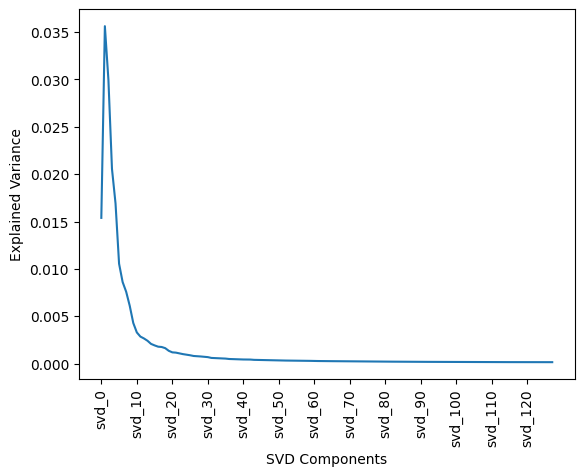

In [28]:
import matplotlib.pyplot as plt

# Create x-axis values from 0 to 127
x = range(128)

plt.plot(x, svd_loaded.explained_variance_ratio_)


tick_locations = range(0, 128, 10)
tick_labels = [f"svd_{i}" for i in tick_locations]

plt.xticks(tick_locations, tick_labels, rotation=90)

plt.xlabel("SVD Components")
plt.ylabel("Explained Variance")

plt.show()

In [30]:
pd.DataFrame(df_use.X.toarray())

,0,1,2,3,4,5,6,7,8,9,...,21991,21992,21993,21994,21995,21996,21997,21998,21999,22000
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.878369,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.847458,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.742516,0.000000,0.742516,0.742516,0.000000,...,0.000000,0.000000,0.742516,1.163910,0.000000,0.0,0.000000,0.742516,0.742516,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.533954,0.533954,0.000000,0.000000,...,0.533954,0.000000,0.880177,1.510350,0.000000,0.0,0.000000,0.533954,0.880177,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.931775,0.000000,0.000000,...,0.000000,0.931775,0.931775,0.931775,0.000000,0.0,0.570701,0.931775,0.570701,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119186,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.674369,...,0.000000,0.000000,0.000000,0.674369,0.000000,0.0,0.000000,0.000000,0.674369,0.000000
119187,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.842724,0.000000,...,0.842724,0.000000,0.000000,0.842724,0.000000,0.0,0.000000,0.000000,1.293458,0.000000
119188,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.026762,0.000000,0.000000,0.0,0.000000,1.026762,3.261481,1.522577
119189,0.0,0.0,0.0,0.0,0.0,0.000000,0.628728,0.628728,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.628728,0.628728,0.0,0.000000,0.628728,0.000000,0.000000


In [28]:
result_svd = svd_loaded.transform(df_use.X)
pd.DataFrame(result_svd)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,83.281059,-6.563687,-7.516498,3.435710,-8.191517,0.490795,1.647467,1.167566,-2.731280,0.720675,...,-0.461493,0.585050,-1.581415,0.836849,0.382400,-0.156138,0.217115,-1.089436,0.320313,-0.283507
1,82.476021,-4.765861,-10.963954,4.910066,-9.272614,2.528403,1.478672,-0.542885,1.255432,-1.079146,...,0.647600,0.107936,-0.032480,0.654824,-1.018406,-0.227682,0.659757,-0.660315,0.035743,-0.300174
2,81.887825,-4.920454,-1.931673,2.259549,9.677330,8.383811,-4.828906,-5.170604,1.990828,2.317710,...,-0.496323,-0.113403,-0.108198,-0.570026,0.079433,-0.277450,0.056143,0.261884,0.777797,0.443342
3,89.633156,-3.208730,-0.260160,-10.103559,-5.034528,4.842731,7.163779,0.373034,0.722552,1.930781,...,0.722054,0.038972,-0.204838,0.461687,-0.054005,0.539513,0.116842,-1.182438,0.060562,0.490287
4,91.496529,-9.532856,9.166341,-4.111490,1.666674,1.485301,-1.393139,0.572235,-8.316234,1.448510,...,0.606755,0.134050,0.012063,-0.335895,-0.268094,-0.309250,-1.055441,0.625480,-0.965516,0.856348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119186,83.781845,0.167031,-7.625717,1.275733,-3.755007,0.783169,3.680861,-0.550919,0.846298,4.215569,...,0.160800,-0.029528,0.229397,0.183500,-0.215809,0.304162,-0.360400,0.083125,0.177883,-0.192456
119187,79.464088,5.140545,-11.211595,1.652752,0.794648,-1.240072,1.638385,-1.543988,0.893215,3.862797,...,-0.835871,0.112912,-0.737379,0.053217,0.642194,-0.993530,0.337827,1.329903,0.574967,-0.944368
119188,79.684784,9.428175,13.557551,15.520265,10.519946,-4.048905,20.526196,5.015813,0.767968,-0.664279,...,0.058709,1.303856,-0.980460,0.768295,0.051655,-0.200603,-0.019306,-0.950464,0.350242,0.713778
119189,83.006081,-2.171104,0.325797,3.708027,13.180615,7.374112,-3.657790,-4.584086,2.395246,0.864618,...,-0.204323,0.719307,0.660412,-0.031210,-0.090650,-0.354362,0.136426,0.191543,-0.011333,0.643190


In [24]:
pd.DataFrame(svd_loaded.inverse_transform(result_svd))

,0,1,2,3,4,5,6,7,8,9,...,21991,21992,21993,21994,21995,21996,21997,21998,21999,22000
0,0.015529,0.040509,0.005837,0.005167,-0.000056,0.002443,0.329689,0.251828,0.084986,0.317316,...,0.081604,0.241855,0.296246,0.744558,0.012336,0.030165,0.092147,0.076733,0.522615,0.088361
1,0.010951,0.053049,0.013280,0.011947,0.000190,0.002833,0.322214,-0.006749,0.084460,0.215369,...,0.151327,0.236919,0.201090,0.579479,0.008537,0.022297,0.109125,0.114708,0.362774,0.068842
2,0.009063,0.024381,0.001220,0.007648,0.000836,0.127598,0.339779,0.247897,0.037229,0.230652,...,0.243786,0.308060,0.387767,0.813746,0.014519,0.033668,0.145483,0.310352,0.230213,0.143556
3,0.007655,0.031088,-0.023502,0.028080,0.000108,0.006588,0.427779,0.263034,0.027295,0.322202,...,0.154222,0.329613,0.494843,0.960081,0.012328,0.038291,0.233187,0.250874,0.978468,0.224227
4,0.009417,0.032593,-0.000713,-0.024297,0.001406,0.055655,0.398575,0.535276,0.019107,0.383890,...,0.316944,0.371642,0.539522,1.288919,0.012183,0.043417,0.173452,0.341091,0.239496,0.162029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119186,0.015733,0.057813,0.006062,0.037010,-0.000135,-0.002647,0.279221,0.260975,0.049477,0.233755,...,0.197613,0.184985,0.262708,0.796736,0.008437,0.028229,0.130628,0.172401,0.823640,0.125901
119187,0.019262,0.056759,0.005899,0.066517,0.000005,-0.025406,0.134020,0.362347,0.047260,0.202044,...,0.184178,0.167482,0.158280,0.458609,0.013713,0.033707,0.144928,0.216161,0.786325,0.136676
119188,0.017269,0.040909,-0.014345,0.010764,-0.000215,0.019802,0.221343,0.702480,0.001782,0.223733,...,0.229775,0.137897,0.145190,0.400716,0.006769,0.026061,0.134249,0.453575,2.759427,0.305227
119189,0.010669,0.039391,-0.000274,0.032523,0.000437,0.108123,0.314973,0.331260,0.056133,0.244011,...,0.219728,0.321958,0.395030,0.652019,0.011643,0.042224,0.178641,0.405547,0.174046,0.219362


In [29]:
result_svd[:,9]

array([ 0.72067463, -1.0791457 ,  2.3177102 , ..., -0.6642791 ,
        0.8646184 ,  3.9578958 ], dtype=float32)

In [39]:
# shap model #16: most important features are svd 2, 9, 1, 16
svd_loaded.components_[2]

array([-4.1849897e-04, -3.4455024e-05,  7.1493894e-05, ...,
        2.9243894e-03,  6.1457097e-03,  4.0481603e-03], dtype=float32)

In [58]:
svd_comp_norm = svd_loaded.components_ / np.sum(svd_loaded.components_, axis=1, keepdims=True)
svd_comp_norm

array([[ 2.6392311e-06,  6.3158550e-06,  8.3349960e-07, ...,
         4.4053271e-05,  1.2457641e-04,  3.2312804e-05],
       [ 2.2104937e-04,  2.5883131e-04,  3.5423081e-04, ...,
         6.7786383e-04,  9.1700982e-03,  2.0220426e-03],
       [-1.8097935e-05, -1.4900031e-06,  3.0917445e-06, ...,
         1.2646485e-04,  2.6577045e-04,  1.7506217e-04],
       ...,
       [-1.4238412e-04,  3.6831855e-04, -2.2385879e-04, ...,
         1.4084906e-04,  1.6358774e-02, -2.6114541e-04],
       [-7.2569717e-03, -4.3067262e-03,  6.1087823e-03, ...,
        -2.3890125e-02,  8.1661791e-02, -1.3632994e-02],
       [-4.7165906e-04,  7.9879741e-04, -9.2265371e-05, ...,
         5.1631322e-03,  2.0002615e-02,  4.0519389e-04]], dtype=float32)

In [68]:
svd_comp_norm[2]

array([-1.8097935e-05, -1.4900031e-06,  3.0917445e-06, ...,
        1.2646485e-04,  2.6577045e-04,  1.7506217e-04], dtype=float32)

In [66]:
np.savetxt('svd_comp_norm.txt', svd_comp_norm, delimiter=',')

In [ ]:
#train_feat = pd.read_pickle(feature_path + 'train_svd_64_imp84.pickle')

### merge multi targets, and normalize important gene normalize & all cluster
- Standardized for important genes, combined with MULTI side

In [ ]:
# feature_2nd/cite/cite_merge_cluster.ipynb

In [ ]:
multi_targets = scipy.sparse.load_npz(raw_multi_path + "train_multi_raw_targets_values.sparse.npz")
multi_cols = np.load(raw_multi_path +  "train_multi_raw_targets_idxcol.npz", allow_pickle=True)
multi_all_cols = multi_cols["columns"]

In [ ]:
multi_col_names_84 = [i.split('_')[0] for i in important_cols_84]
multi_col_names_120 = [i.split('_')[0] for i in important_cols_120]

In [ ]:
use_imp_cols_cite_84 =  [i for i, j in enumerate(train_column) if j in important_cols_84]
use_imp_cols_multi_84 =  [i for i, j in enumerate(multi_all_cols) if j in multi_col_names_84]

use_imp_cols_cite_120 =  [i for i, j in enumerate(train_column) if j in important_cols_120]
use_imp_cols_multi_120 =  [i for i, j in enumerate(multi_all_cols) if j in multi_col_names_120]

In [ ]:
def make_imp_norm_features(multi_targets, cite_train_inputs, cite_test_inputs, use_imp_cols_cite, use_imp_cols_multi, all_cluster, fname, all_cluster_feat = False):

    multi_train = multi_targets[:, use_imp_cols_multi]
    multi_len = multi_train.shape[0]

    cite_train = train_inputs[:, use_imp_cols_cite]
    cite_test = test_inputs[:, use_imp_cols_cite]
    cite_train_len = cite_train.shape[0]
    cite_test_len = cite_test.shape[0]

    all_imp = scipy.sparse.vstack([multi_train, cite_train, cite_test])
    imp_df = pd.DataFrame(all_imp.toarray())

    if all_cluster_feat == True:
        all_cluster_df = pd.concat([imp_df.reset_index(drop=True), all_cluster.reset_index(drop=True)], axis = 1)
        all_cluster_gp_df = all_cluster_df.groupby('leiden').mean().reset_index()
        result_df = all_cluster_df[['leiden']].merge(all_cluster_gp_df, on = 'leiden', how = 'left')
        result_df.drop(['leiden'], axis = 1, inplace = True)

        train_feature = result_df[multi_targets.shape[0]: multi_targets.shape[0] + cite_train_len]
        test_feature = result_df[multi_targets.shape[0] + cite_train_len:]

        pd.DataFrame(train_feature).add_prefix('all_cluster_').to_pickle(feature_path + 'cite_train_all_cluster.pickle')
        pd.DataFrame(test_feature).add_prefix('all_cluster_').to_pickle(feature_path + 'cite_test_all_cluster.pickle')

    sc = StandardScaler()
    imp_df = sc.fit_transform(imp_df)

    train_imp = pd.DataFrame(imp_df[multi_len:multi_len + cite_train_len], index = train_ids['index']).add_prefix('imp_merge_norm_120_')
    test_imp = pd.DataFrame(imp_df[multi_len + cite_train_len:], index = test_ids['index']).add_prefix('imp_merge_norm_120_')

    train_imp.to_pickle(feature_path + f'train_imp_merge_norm_{fname}.pickle')
    test_imp.to_pickle(feature_path + f'test_imp_merge_norm_{fname}.pickle')

In [ ]:
make_imp_norm_features(multi_targets, train_inputs, test_inputs, use_imp_cols_cite_84, use_imp_cols_multi_84, all_cluster, '84', True)
make_imp_norm_features(multi_targets, train_inputs, test_inputs, use_imp_cols_cite_120, use_imp_cols_multi_120, all_cluster, '120', False)

In [ ]:
del multi_targets
gc.collect()

### cluster features
- The average of each leiden cluster for important proteins was used as feature.

In [ ]:
cluster.shape

In [ ]:
imp_84_df = pd.DataFrame(np.concatenate([train_inputs[:,use_imp_cols_84].toarray(), \
                                    test_inputs[:,use_imp_cols_84].toarray()]), \
                                    columns = important_cols_84)
imp_120_df = pd.DataFrame(np.concatenate([train_inputs[:,use_imp_cols_120].toarray(), \
                          test_inputs[:,use_imp_cols_120].toarray()]), \
                          columns = important_cols_120)

In [ ]:
imp_84_other_df = pd.DataFrame(np.concatenate([train_inputs[:,use_cols_84].toarray(), \
                                               test_inputs[:,use_cols_84].toarray()]), \
                               columns = norm_cols_84)
imp_120_other_df = pd.DataFrame(np.concatenate([train_inputs[:,use_cols_120].toarray(), \
                                                test_inputs[:,use_cols_120].toarray()]), \
                                columns = norm_cols_120)

In [ ]:
cluster_df_imp_84 = pd.concat([cluster.reset_index(drop=True), imp_84_df], axis = 1)
cluster_df_imp_120 = pd.concat([cluster.reset_index(drop=True), imp_120_df], axis = 1)

cluster_df_84 = pd.concat([cluster.reset_index(drop=True), imp_84_other_df], axis = 1)
cluster_df_120 = pd.concat([cluster.reset_index(drop=True), imp_120_other_df], axis = 1)

In [ ]:
del imp_84_other_df, imp_120_other_df
gc.collect()

In [ ]:
def make_cluser_df(cluster_imp_df, cluster_df, dims):

    # imp
    leiden_mean = cluster_imp_df.groupby('leiden').mean().reset_index()
    leiden_mean_df = cluster_imp_df[['leiden']].merge(leiden_mean, on = ['leiden'], how = 'left')
    leiden_mean_df.drop(['leiden'], axis = 1, inplace = True)

    leiden_mean_df[:len(train_index)].add_prefix('cluster_mean').to_pickle(feature_path + f'train_cite_cluster{dims}_mean.pickle')
    leiden_mean_df[len(train_index):].add_prefix('cluster_mean').to_pickle(feature_path + f'test_cite_cluster{dims}_mean.pickle')

    # other
    cluster_df['leiden'] = cluster_df['leiden'].astype(int)
    leiden_mean = cluster_df.groupby('leiden').mean().add_prefix('mean_').reset_index()
    svd = TruncatedSVD(n_components=64, random_state=1) # 512
    result_svd = svd.fit_transform(leiden_mean)

    leiden_mean_df = pd.DataFrame(result_svd).add_prefix('all_c_norm_')
    leiden_mean_df = leiden_mean_df.reset_index().rename(columns = {'index': 'leiden'})
    leiden_mean_df = cluster_df[['leiden']].merge(leiden_mean_df, on = ['leiden'], how = 'left')
    leiden_mean_df.drop(['leiden'], axis = 1, inplace = True)

    leiden_mean_df[:len(train_index)].to_pickle(feature_path + f'train_cite_cluster_{dims}_all_mean.pickle')
    leiden_mean_df[len(train_index):].to_pickle(feature_path + f'test_cite_cluster_{dims}_all_mean.pickle')

In [ ]:
make_cluser_df(cluster_df_imp_84, cluster_df_84, '84')
make_cluser_df(cluster_df_imp_120, cluster_df_120, '120')

In [ ]:
#train_svd_64_c_norm
#train_imp_c_norm_84
#train_svd_64_c_norm_120
#train_imp_c_norm_120

### cnorm
- Features subtracted from the original features by subtracting the average of the features for each cluster

In [ ]:
def make_cnorm_df(cluster, all_inputs):

    print('make norm data')
    cluster_df = pd.concat([cluster.reset_index(drop=True),
                            pd.DataFrame(all_inputs.toarray()).reset_index(drop=True)], axis = 1)
    cluster_mean_df = cluster_df.groupby('leiden').mean().add_prefix('mean_').reset_index()

    del all_inputs
    gc.collect()

    norm_list = []

    for i in tqdm(range(1, len(train_column) + 1)):
        cluster_split_df = cluster_df.iloc[:,[0, i]]
        cluster_split_df = cluster_split_df.merge(cluster_mean_df.iloc[:,[0, i]], on = 'leiden', how = 'left')
        norm_list.append(cluster_split_df.iloc[:,1] / cluster_split_df.iloc[:,2])

    del cluster_df, cluster_mean_df, cluster_split_df
    gc.collect()

    norm_df = pd.concat(norm_list, axis = 1)

    del norm_list
    gc.collect()

    norm_df.fillna(0, inplace = True)
    norm_df = norm_df.astype(np.float32)
    norm_df = np.log1p(norm_df)
    norm_df.columns = train_column


    # imp
    print('make imp cnorm')
    important_df = norm_df[important_cols_84]
    train_imp = pd.DataFrame(important_df[:len(train_index)]).add_prefix('imp_c_norm_')
    test_imp = pd.DataFrame(important_df[len(train_index):]).add_prefix('imp_c_norm_')
    train_imp.to_pickle(feature_path + f'train_imp_c_norm_84.pickle')
    test_imp.to_pickle(feature_path + f'test_imp_c_norm_84.pickle')

    important_df = norm_df[important_cols_120]
    train_imp = pd.DataFrame(important_df[:len(train_index)]).add_prefix('imp_c_norm_')
    test_imp = pd.DataFrame(important_df[len(train_index):]).add_prefix('imp_c_norm_')
    train_imp.to_pickle(feature_path + f'train_imp_c_norm_120.pickle')
    test_imp.to_pickle(feature_path + f'test_imp_c_norm_120.pickle')

    # norm
    print('make other cnorm')
    other_df = norm_df[norm_cols_84]
    svd = TruncatedSVD(n_components=64, random_state=1) # 512
    result_svd = svd.fit_transform(other_df)

    train_cite_pp = pd.DataFrame(result_svd[:len(train_index)])
    test_cite_pp = pd.DataFrame(result_svd[len(train_index):])
    train_cite_pp.to_pickle(feature_path + 'train_svd_64_c_norm.pickle')
    test_cite_pp.to_pickle(feature_path + 'test_svd_64_c_norm.pickle')

    # norm_120
    other_df = norm_df[norm_cols_120]
    svd = TruncatedSVD(n_components=64, random_state=1) # 512
    result_svd = svd.fit_transform(other_df)

    train_cite_pp = pd.DataFrame(result_svd[:len(train_index)])
    test_cite_pp = pd.DataFrame(result_svd[len(train_index):])
    train_cite_pp.to_pickle(feature_path + 'train_svd_64_c_norm_120.pickle')
    test_cite_pp.to_pickle(feature_path + 'test_svd_64_c_norm_120.pickle')

In [ ]:
make_cnorm_df(cluster, all_inputs)

### spec cluster
- SpectralClustering feature

In [ ]:
#scluster_train = pd.read_pickle(SAVE_DIR + 'train_spec_cluster_128.pickle')
#scluster_test = pd.read_pickle(SAVE_DIR + 'test_spec_cluster_128.pickle')

In [ ]:
s_cluster_df = pd.concat([s_cluster.reset_index(drop=True),
                          pd.DataFrame(all_inputs.toarray()).reset_index(drop=True)], axis = 1)
s_cluster_mean_df = s_cluster_df.groupby('s_cluster').mean().add_prefix('mean_').reset_index()

In [ ]:
%%time

norm_list = []

for i in tqdm(range(1, len(train_column) + 1)):
    s_cluster_split_df = s_cluster_df.iloc[:,[0, i]]
    s_cluster_split_df = s_cluster_split_df.merge(s_cluster_mean_df.iloc[:,[0, i]], on = 's_cluster', how = 'left')
    norm_list.append(s_cluster_split_df.iloc[:,1] / s_cluster_split_df.iloc[:,2])

del s_cluster_df, s_cluster_mean_df, s_cluster_split_df
gc.collect()

norm_df = pd.concat(norm_list, axis = 1)
norm_df = norm_df.astype(np.float32)

del norm_list
gc.collect()

norm_df.fillna(0, inplace = True)
norm_df = np.log1p(norm_df)
norm_df.columns = train_column

important_df = norm_df[important_cols_84]

train_imp = pd.DataFrame(important_df[:len(train_index)]).add_prefix('imp_s_norm_')
test_imp = pd.DataFrame(important_df[len(train_index):]).add_prefix('imp_s_norm_')

train_imp.to_pickle(feature_path + 'train_imp_s_norm_84.pickle')
test_imp.to_pickle(feature_path + 'test_imp_s_norm_84.pickle')

In [ ]:
del norm_df
gc.collect()

### column cluster
- Clusters were applied to the columns, and the average of the column expression for each cluster was used as feature.

In [ ]:
all_inputs_T = all_inputs.T
all_inputs_T = sc.AnnData(X = all_inputs_T)
sc.pp.normalize_per_cell(all_inputs_T, counts_per_cell_after = 1e6)
sc.pp.log1p(all_inputs_T)
svd = TruncatedSVD(n_components=128, random_state=1) # 512
result_col_svd = svd.fit_transform(all_inputs_T.X)
col_svd = sc.AnnData(X = result_col_svd)

sc.pp.neighbors(col_svd, use_rep = 'X', n_neighbors=16, method='umap')
sc.tl.leiden(col_svd)

col_cluster_df = pd.DataFrame(list(col_svd.obs['leiden']), index = train_column, columns = ['col_cluster'])
col_cluster_df['col_cluster'] = col_cluster_df['col_cluster'].astype(int)
col_cluster_df = col_cluster_df.reset_index()

In [ ]:
col_cluster_mean = pd.DataFrame()

for i in tqdm(range(16)):
    col_list = list(col_cluster_df[col_cluster_df['col_cluster'] == i].index)
    col_cluster_mean[f'cluster_mean_{i}'] = np.squeeze(np.asarray(all_inputs[:,col_list].mean(1)))

In [ ]:
col_cluster_mean.iloc[:train_num,:].add_prefix('col_cluster_mean_').to_pickle(feature_path + 'cite_train_col_mean.pickle')
col_cluster_mean.iloc[train_num:,:].add_prefix('col_cluster_mean_').to_pickle(feature_path + 'cite_test_col_mean.pickle')

In [ ]:
del all_inputs_T
gc.collect()

### cellt_mean features
- Take the average of expression counts of important genes for each cell type

In [ ]:
df_meta_cite = df_meta[df_meta['technology'] == 'citeseq']
df_meta_cite

In [ ]:
imp_84_df = pd.DataFrame(np.concatenate([train_inputs[:,use_imp_cols_84].toarray(), \
                                    test_inputs[:,use_imp_cols_84].toarray()]), \
                                    columns = important_cols_84)
imp_120_df = pd.DataFrame(np.concatenate([train_inputs[:,use_imp_cols_120].toarray(), \
                          test_inputs[:,use_imp_cols_120].toarray()]), \
                          columns = important_cols_120)

In [ ]:
imp_84_df

In [ ]:
train_index

In [ ]:
imp_84_df.index = list(train_index) + list(test_index)
imp_120_df.index = list(train_index) + list(test_index)

In [ ]:
imp_84_df = imp_84_df.reset_index().rename(columns = {'index': 'cell_id'})
imp_120_df = imp_120_df.reset_index().rename(columns = {'index': 'cell_id'})

In [ ]:
imp_84_df = imp_84_df.merge(df_meta_cite[['cell_id', 'cell_type']], on = 'cell_id', how = 'left')
imp_120_df = imp_120_df.merge(df_meta_cite[['cell_id', 'cell_type']], on = 'cell_id', how = 'left')

In [ ]:
imp_84_df.drop(['cell_id'], axis = 1, inplace = True)
imp_120_df.drop(['cell_id'], axis = 1, inplace = True)

In [ ]:
cell_mean_84 = imp_84_df.groupby('cell_type').mean().reset_index()
imp_84_df = imp_84_df[['cell_type']].merge(cell_mean_84, on = ['cell_type'], how = 'left')
imp_84_df.drop(['cell_type'], axis = 1, inplace = True)
imp_84_df = imp_84_df.fillna(0)

In [ ]:
cell_mean_120 = imp_120_df.groupby('cell_type').mean().reset_index()
imp_120_df = imp_120_df[['cell_type']].merge(cell_mean_120, on = ['cell_type'], how = 'left')
imp_120_df.drop(['cell_type'], axis = 1, inplace = True)
imp_120_df = imp_120_df.fillna(0)

In [ ]:
imp_84_df[:len(train_index)].add_prefix('cell_mean').to_pickle(feature_path + 'train_cite_cellt_mean.pickle')
imp_84_df[len(train_index):].add_prefix('cell_mean').to_pickle(feature_path + 'test_cite_cellt_mean.pickle')

In [ ]:
imp_120_df[:len(train_index)].add_prefix('cell_mean').to_pickle(feature_path + 'train_cite_cellt_mean_120.pickle')
imp_120_df[len(train_index):].add_prefix('cell_mean').to_pickle(feature_path + 'test_cite_cellt_mean_120.pickle')

### cell type ratio

In [ ]:
df_meta = pd.read_csv(raw_path_base + "metadata.csv")
cluster = pd.read_pickle(raw_path + 'cite_cluster.pickle')
cluster['cell_id'] = list(train_index) + list(test_index)

In [ ]:
cluster = cluster.merge(df_meta, on = 'cell_id', how = 'left')
cluster_df = pd.crosstab([cluster['day'], cluster['donor'], cluster['cell_type']],
            cluster['leiden'], normalize=True)
cluster_df.columns = cluster_df.columns.astype(str)
cluster_df = cluster_df.reset_index()
cluster = cluster[['day', 'donor', 'cell_type']].merge(cluster_df, on = ['day', 'donor', 'cell_type'], how = 'left')

In [ ]:
cluster.iloc[:len(train_index),3:].add_prefix('cluster_celltype_').to_pickle(feature_path + 'train_cite_cluster_celltype_ratio.pickle')
cluster.iloc[len(train_index):,3:].add_prefix('cluster_celltype_').to_pickle(feature_path + 'test_cite_cluster_celltype_ratio.pickle')